<a href="https://colab.research.google.com/github/NguyenYen153/My-code/blob/master/processing_classical_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pyvi

     |████████████████████████████████| 8.5MB 4.4MB/s 
     |████████████████████████████████| 747kB 41.0MB/s 


In [0]:
from pyvi import ViTokenizer
import re, os, string
import pandas as pd
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
import unicodedata as ud
import random
import csv
import time
from tqdm import tqdm
from gensim import utils
from gensim.models.doc2vec import LabeledSentence, TaggedDocument
from gensim.models import Doc2Vec

In [0]:
from sklearn.svm import LinearSVC
from gensim import corpora, matutils
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
data_path = '/content/drive/My Drive/data/VNFN/'
file_stopwords = 'Dictionaries/Stopwords_vi.txt'
d2v_model_path = 'em_model/doc2vec_model.vec'
w2v_path_pre_trained = 'em_model/cc.vi.300.vec'
w2v_model_path = '/content/drive/My Drive/LuanVan/model/word2vec_skipgram.model'

In [0]:
csv_226 = 'pre_data/preproc_vn_news_226_tlfr.csv' 
csv_223 = 'pre_data/preproc_vn_news_223_tdlfr.csv' 
csv_news = 'pre_data/preproc_vn_news_376.csv' 
new_data = 'vn_news_376.csv'

In [0]:
def DataReader(data_path, csv_path):
    data = []
    with open(os.path.join(data_path, csv_path), 'r', encoding ='utf-8') as csv_file:
      reader = csv.DictReader(csv_file)
      data = list(reader)
    return data
def get_data(datas):
    texts = []
    labels = []
    for data in datas:
        texts.append(' '.join(data['text'].split()))
        labels.append(data['label'])
    return texts, labels


In [0]:
datas = DataReader(data_path,csv_news)

In [0]:
#data = pd.read_csv(os.path.join(data_path, new_data))

In [0]:
#print(data['label'])

In [0]:
texts =[]
labels = []
for train in datas:
    texts.append(' '.join(train['text'].split()+train['title'].split()) +'.'+train['domain'])
    labels.append(train['label'])
print(len(texts))


376


In [0]:
import numpy as np
import pickle
from collections import defaultdict
import sys, re
import pandas as pd
def build_data_cv(data_file):
    """
    Loads data and split into 10 folds.
    """
    vocab = defaultdict(float)
    with open(data_file, "r", encoding ='utf-8') as f:
        data = pd.read_csv(f)
        texts = data['text'].values + data['title'] + data['domain']
        labels = data['label'].values
        tex = []
        for text in texts:
            tex.append(''.join(preparing_text(text)))
        words = set(str(tex).split())#(i.split() for i in tex)
        for word in words:
            vocab[word] += 1
    return labels,tex, vocab
 
def add_unknown_words(word_vecs, vocab, min_df=1, k=300):
    """
    For words that occur in at least min_df documents, create a separate word vector.    
    0.25 is chosen so the unknown vectors have (approximately) same variance as pre-trained ones
    """
    for word in vocab:
        if word not in word_vecs and vocab[word] >= min_df:
            word_vecs[word] = np.random.uniform(-0.25,0.25,k)  


In [0]:
#X_text, y_labels
X_train, X_test, y_train, y_test = train_test_split(texts,labels, test_size=0.25)
len(y_test)


94

In [0]:
#convert label to number
y_train_num = []
y_test_num = []
l=0
for i in y_train:
    if i == '0':
      y_train_num.append(0)
    elif i== '1':
      y_train_num.append(1)
for i in y_test:
    if i == '0':
      y_test_num.append(0)
    elif i== '1':
      y_test_num.append(1)
y_test = y_test_num
y_train = y_train_num


In [0]:
y = []
for i in labels:
    if i == '0':
      y.append(0)
    elif i== '1':
      y.append(1)

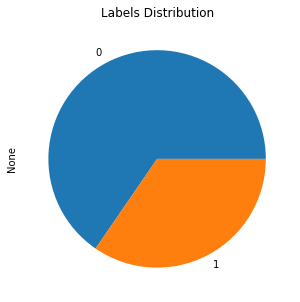

In [0]:
# Plot of label types numbers
pd.Series(labels).value_counts().plot(
    kind='pie', title='Labels Distribution', figsize=(5, 5))
plt.show()

In [0]:
pd.Series(labels).value_counts()

0    246
1    130
dtype: int64

In [0]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

282 282 94 94


In [0]:
with open(os.path.join(data_path, file_stopwords)) as f:
    list_stopwords = f.read()

#**BUILDING MODELS**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn.decomposition import TruncatedSVD

In [0]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV , StratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier#решающее дерево
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier#random tree
from sklearn.neighbors import KNeighborsClassifier#k-NN
import lightgbm as lgb#LightGBM 
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, f1_score, auc, accuracy_score, confusion_matrix, classification_report 
from scipy import interp
from sklearn.svm import SVC
import itertools
from IPython.display import display
from collections import defaultdict, Counter
from sklearn.decomposition import NMF
import seaborn as sns
sns.set_style('white')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**FIND PARAMETERS**

In [0]:
#Tìm parameter để kq tốt nhất
#
param_dist_naive = {}
#
C_svm= np.linspace(1,10,10)
kernel =['rbf', 'poly', 'sigmoid']
degree = [2,3,4,5]
gamma = np.linspace(0,1,5)
param_dist_svm ={'C':C_svm,'kernel':kernel, 'degree':degree, 'gamma':gamma}

#2.parameters LogisticRegression
C_lr= np.linspace(1,10,10)
penalty =['l1', 'l2']
param_dist_lr ={'C':C_lr,'penalty':penalty}

#3. parameters DecisionTreeClassifier
max_depth = np.arange(20, 60, 2)
param_dist_dt ={'max_depth': max_depth}

#4. parameters knn
param_dist_knn = {'n_neighbors': np.arange(3,15,2), 
                  'weights':['uniform', 'distance'],
                  'metric':['euclidean', 'manhattan']}

#5. for LGBMClassifier
param_dist_lgb = {
          'learning_rate': np.arange(0.01, 0.1,0.02),
          'n_estimators': np.arange(20,100,20),
          'num_leaves':np.arange(50,150,20),
          'max_depth':np.arange(7,9,1)
}

# run randomized search
#random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   #cv=5, iid=False)
#viet ham tim parameters tot nhat
def search_best_parameters(models, param_dists, X_train, y_train):
    res_search = []
    for model,param in zip(models,param_dists):
        grid_search = GridSearchCV(model, param_grid=param, cv = 5, scoring = 'accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        res_search.append(grid_search.best_estimator_)
        #print(grid_search.best_estimator_)
    return res_search

In [0]:
def classifier_comparison(x_train, y_train, x_test,y_test, vectorizer1,vectorizer2,vectorizer3,n_splits=3):#normalier
    # Classifier names & initializations
    names = [ "Naive","SVM", "LogisticRegression"," DecisionTreeClassifie", 
             "Nearest Neighbors", " LightGBM Classifier"]
  
    classifiers = [
        GaussianNB(),
        SVC(probability=True),
        LogisticRegression(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(),
        lgb.LGBMClassifier()
        ]

    # Split & shuffle data using Stratified K Fold
    #kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)

    # Calculate accuracy, f1 & auc over all splits, classifiers
    #count = 0
    acc_dict = defaultdict(list)
    f1_dict = defaultdict(list)
    auc_dict = defaultdict(list)
    '''
    for train_index, test_index in kfold.split(x_train, y_train):
        xtrain, ytrain = np.array(x_train)[train_index],np.array(y_train)[train_index]
        xtest, ytest = np.array(x_train)[test_index], np.array(y_train)[test_index]
        print('Iteration: ', count)
     '''
        # iterate over classifiers
    for clf in classifiers:
          pipeline = Pipeline([
              ('count', vectorizer1),('vectorizer1', vectorizer2),('vectorizer2',vectorizer3),
              ('classifier', clf)])
          clf_name = clf.__class__.__name__
          print('Fitting ', clf_name)
          pipeline.fit(x_train, y_train)
          predictions = pipeline.predict(x_test)
          accuracy = accuracy_score(y_test, predictions)

          # Store the predictions probability
          predictions_prob = pipeline.predict_proba(x_test)[:, 1]

          # Calculate False Positive rate, True Positive Rate, AUC Thresholds
          fpr, tpr, auc_thresholds = roc_curve(y_test, predictions_prob)

          # Append results in default dict of lists
          acc_dict[clf_name].append(accuracy)
          f1_dict[clf_name].append(
              f1_score(y_test, predictions, average=None))
          auc_dict[clf_name].append(auc(fpr, tpr))

    #count += 1

    return acc_dict, f1_dict, auc_dict

In [0]:
def metric_avg(metric_dict):

    # Dataframe containing classifier name & score
    metric_df = pd.DataFrame.from_dict(metric_dict, orient='index')

    #acc_df = acc_df.add_suffix('_Iteration')
    metric_df.columns = [
        str(col+1) + '_Iteration' for col in metric_df.columns]

    # Flatten scores
    metric_df = metric_df.applymap(lambda x: pd.Series(x).mean())

    # Calculate average score
    metric_df['avg'] = metric_df.mean(axis=1)

    metric_df = (metric_df*100).round(2)

    return metric_df

# Plot metrices average


def plot_metrics(sorted_acc_df, sorted_f1_df, sorted_auc_df):

    nb_rows, nb_cols = 1, 3
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(18, 12))

    # Plot metrices average

    for ax, (metric, df) in zip(axes, zip(['Accuracy AVG', 'F1 AVG', 'AUC AVG'], [sorted_acc_df, sorted_f1_df, sorted_auc_df])):

        # Plot a barplot containing classifier name & metrics i.e. accuracy, f1 score & auc
        ax = sns.barplot(x='avg', y=df.index, ax=ax, data=df)
        ax.set(xlabel=metric)
        ax.set_xlim(df['avg'].max()-10, df['avg'].max()+10)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

    # Remove spines

    sns.despine()

**TFIDF-ngram = 1**

In [0]:
vec_tfidf = TfidfTransformer()
vec_svd = TruncatedSVD(n_components=300, random_state=42)
vec_count = CountVectorizer(ngram_range = (1,1))

In [0]:
%%time
# Call the classifier_comparison module & save the results
acc_dict_tfidf, f1_dict_tfidf, auc_dict_tfidf = classifier_comparison(X_train, y_train,X_test,y_test,vectorizer1=vec_count
                                                    ,vectorizer2=vec_tfidf, vectorizer3=vec_svd, n_splits=3)

Fitting  GaussianNB
Fitting  SVC
Fitting  LogisticRegression
Fitting  DecisionTreeClassifier
Fitting  KNeighborsClassifier
Fitting  LGBMClassifier
CPU times: user 14 s, sys: 5.65 s, total: 19.7 s
Wall time: 10.9 s


In [0]:
#accuracy metric
acc_df = metric_avg(acc_dict_tfidf)
sorted_acc_df = acc_df.sort_values(by='avg', ascending=False)
display(sorted_acc_df)

,1_Iteration,avg
SVC,91.49,91.49
LGBMClassifier,90.43,90.43
DecisionTreeClassifier,86.17,86.17
KNeighborsClassifier,86.17,86.17
LogisticRegression,77.66,77.66
GaussianNB,74.47,74.47


In [0]:
# F1 Score of different classifiers
f1_df = metric_avg(f1_dict_tfidf)
sorted_f1_df = f1_df.sort_values(by='avg', ascending=False)
display(sorted_f1_df)

,1_Iteration,avg
SVC,91.09,91.09
LGBMClassifier,90.18,90.18
DecisionTreeClassifier,86.04,86.04
KNeighborsClassifier,85.70,85.70
LogisticRegression,73.56,73.56
GaussianNB,69.48,69.48


In [0]:
# Area under Curve (AUC) of different classifiers
auc_df = metric_avg(auc_dict_tfidf)
sorted_auc_df = auc_df.sort_values(by='avg', ascending=False)
display(sorted_auc_df)

,1_Iteration,avg
SVC,96.92,96.92
LogisticRegression,96.69,96.69
LGBMClassifier,96.27,96.27
KNeighborsClassifier,92.82,92.82
DecisionTreeClassifier,87.06,87.06
GaussianNB,77.86,77.86


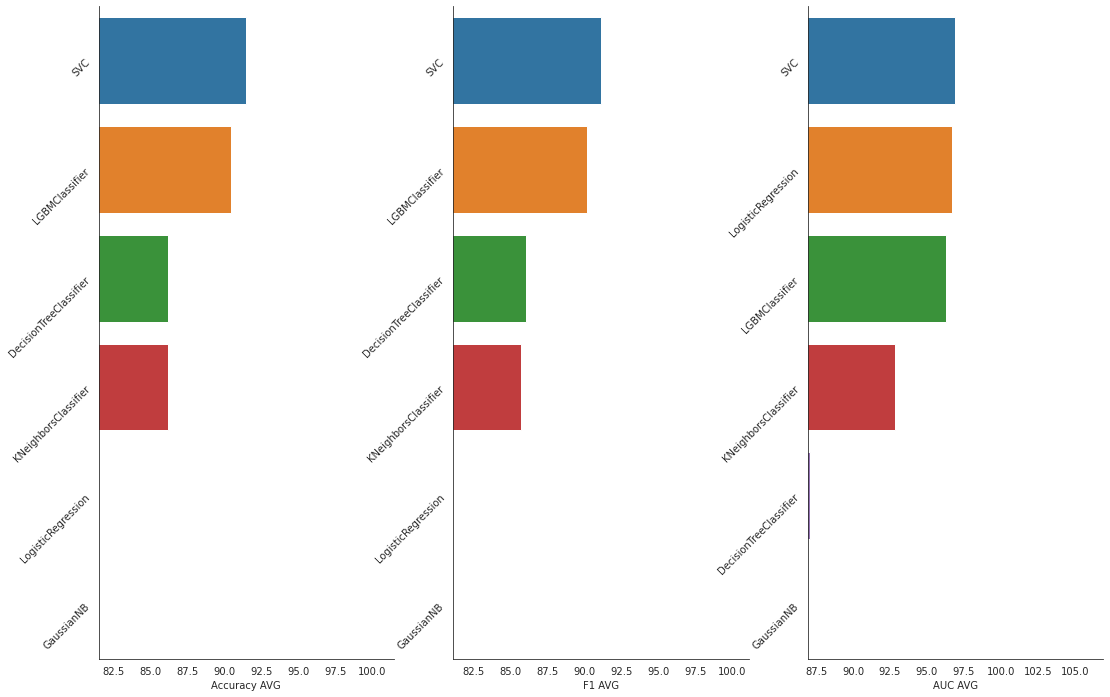

In [0]:
plot_metrics(sorted_acc_df, sorted_f1_df, sorted_auc_df)

**TFIDF-SDV-word, ngram**



In [0]:
%%time
ngram_count = CountVectorizer(analyzer='word',ngram_range=(2,2))
acc_dict_ngram, f1_dict_ngram, auc_dict_ngram = classifier_comparison(X_train, y_train,X_test,y_test, 
                                                    vectorizer1=ngram_count, vectorizer2=vec_tfidf, vectorizer3=vec_svd, n_splits=3)

Fitting  GaussianNB
Fitting  SVC
Fitting  LogisticRegression
Fitting  DecisionTreeClassifier
Fitting  KNeighborsClassifier
Fitting  LGBMClassifier
CPU times: user 1min 15s, sys: 16.5 s, total: 1min 32s
Wall time: 54.1 s


In [0]:
#accuracy metric
acc_df2 = metric_avg(acc_dict_ngram)
sorted_acc_df2 = acc_df2.sort_values(by='avg', ascending=False)
display(sorted_acc_df2)

,1_Iteration,avg
LGBMClassifier,88.30,88.30
KNeighborsClassifier,86.17,86.17
DecisionTreeClassifier,74.47,74.47
SVC,69.15,69.15
GaussianNB,61.70,61.70
LogisticRegression,59.57,59.57


In [0]:

# F1 Score of different classifiers
f1_df2 = metric_avg(f1_dict_ngram)
sorted_f1_df2 = f1_df2.sort_values(by='avg', ascending=False)
display(sorted_f1_df2)

,1_Iteration,avg
LGBMClassifier,87.90,87.90
KNeighborsClassifier,85.70,85.70
DecisionTreeClassifier,70.62,70.62
GaussianNB,61.26,61.26
SVC,59.98,59.98
LogisticRegression,39.66,39.66


In [0]:
# Area under Curve (AUC) of different classifiers

auc_df2 = metric_avg(auc_dict_tfidf)
sorted_auc_df2 = auc_df2.sort_values(by='avg', ascending=False)
display(sorted_auc_df2)

,1_Iteration,avg
SVC,96.92,96.92
LogisticRegression,96.69,96.69
LGBMClassifier,96.27,96.27
KNeighborsClassifier,92.82,92.82
DecisionTreeClassifier,87.06,87.06
GaussianNB,77.86,77.86


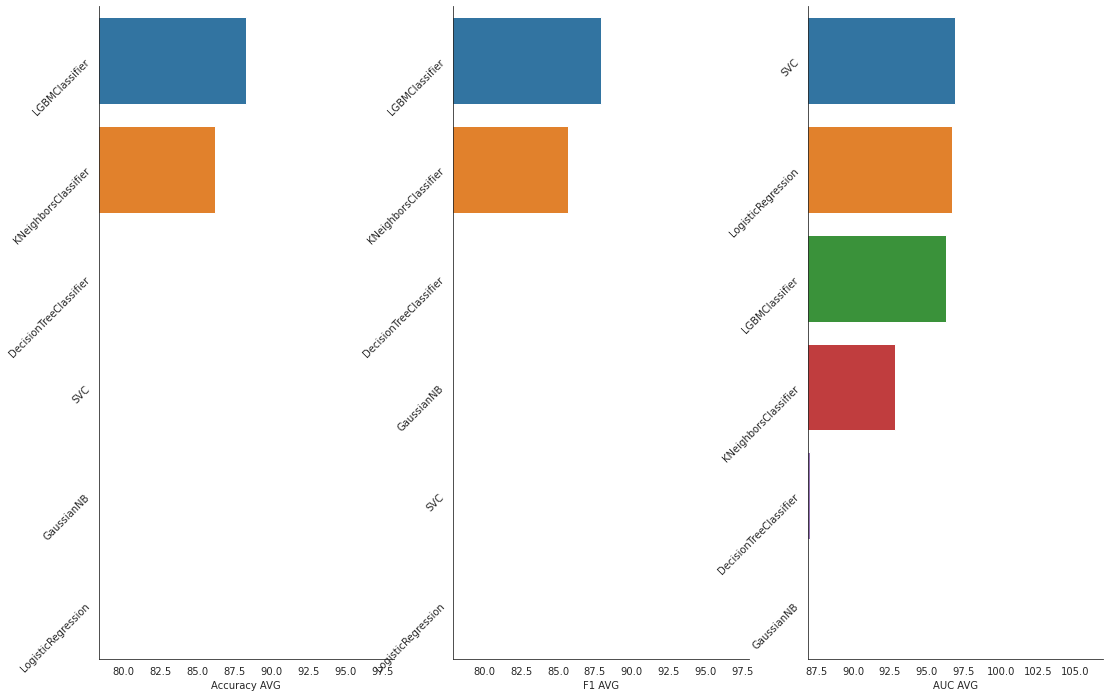

In [0]:
plot_metrics(sorted_acc_df2, sorted_f1_df2, sorted_auc_df2)

In [0]:
%%time
ngram_count3 = CountVectorizer(analyzer='word',ngram_range=(3,3))
acc_dict_ngram3, f1_dict_ngram3, auc_dict_ngram3 = classifier_comparison(X_train, y_train,X_test,y_test, 
                                                    vectorizer1=ngram_count3, vectorizer2=vec_tfidf, vectorizer3=vec_svd, n_splits=3)

Fitting  GaussianNB
Fitting  SVC
Fitting  LogisticRegression
Fitting  DecisionTreeClassifier
Fitting  KNeighborsClassifier
Fitting  LGBMClassifier
CPU times: user 1min 35s, sys: 18 s, total: 1min 53s
Wall time: 1min 6s


In [0]:
acc_df3_w = metric_avg(acc_dict_ngram3)
sorted_acc_df3_w = acc_df3_w.sort_values(by='avg', ascending=False)
display(sorted_acc_df3_w)

f1_df3_w = metric_avg(f1_dict_ngram3)
sorted_f1_df3_w = f1_df3_w.sort_values(by='avg', ascending=False)
display(sorted_f1_df3_w)

auc_df3_w = metric_avg(auc_dict_ngram3)
sorted_auc_df3_w = auc_df3_w.sort_values(by='avg', ascending=False)
display(sorted_auc_df3_w)

,1_Iteration,avg
KNeighborsClassifier,71.28,71.28
DecisionTreeClassifier,63.83,63.83
LGBMClassifier,63.83,63.83
GaussianNB,61.70,61.70
SVC,58.51,58.51
LogisticRegression,58.51,58.51


,1_Iteration,avg
KNeighborsClassifier,64.53,64.53
DecisionTreeClassifier,63.01,63.01
GaussianNB,61.26,61.26
LGBMClassifier,58.39,58.39
SVC,36.91,36.91
LogisticRegression,36.91,36.91


,1_Iteration,avg
LogisticRegression,87.97,87.97
SVC,87.74,87.74
KNeighborsClassifier,84.90,84.90
LGBMClassifier,73.24,73.24
GaussianNB,68.11,68.11
DecisionTreeClassifier,63.12,63.12


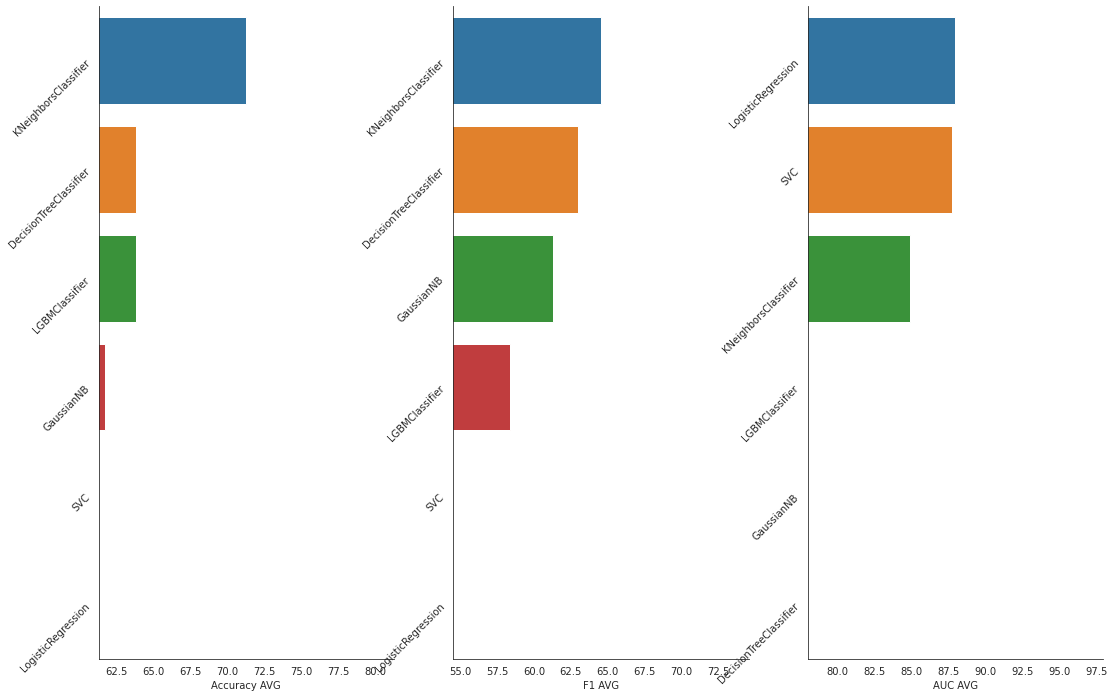

In [0]:
plot_metrics(sorted_acc_df3_w, sorted_f1_df3_w, sorted_auc_df3_w)

**TFIDF-SDV-char ngram **

In [0]:
%%time
ngram_char_count = CountVectorizer(analyzer='char', ngram_range=(1, 4))
acc_dict_ngramchar_tfidf, f1_dict_ngramchar_tfidf, auc_dict_ngramchar_tfidf = classifier_comparison(X_train, y_train,
                                                    X_test,y_test,vectorizer1=ngram_char_count,vectorizer2=vec_tfidf, vectorizer3=vec_svd, n_splits=3)

Fitting  GaussianNB
Fitting  SVC
Fitting  LogisticRegression
Fitting  DecisionTreeClassifier
Fitting  KNeighborsClassifier
Fitting  LGBMClassifier
CPU times: user 1min 54s, sys: 16.2 s, total: 2min 10s
Wall time: 1min 31s


In [0]:
#accuracy metric
acc_df3 = metric_avg(acc_dict_ngramchar_tfidf)
sorted_acc_df3 = acc_df3.sort_values(by='avg', ascending=False)
display(sorted_acc_df3)

,1_Iteration,avg
LGBMClassifier,89.36,89.36
SVC,88.30,88.30
DecisionTreeClassifier,74.47,74.47
LogisticRegression,67.02,67.02
KNeighborsClassifier,67.02,67.02
GaussianNB,59.57,59.57


In [0]:
# F1 Score of different classifiers
f1_df3 = metric_avg(f1_dict_ngramchar_tfidf)
sorted_f1_df3 = f1_df3.sort_values(by='avg', ascending=False)
display(sorted_f1_df3)

,1_Iteration,avg
LGBMClassifier,88.48,88.48
SVC,87.55,87.55
DecisionTreeClassifier,71.12,71.12
KNeighborsClassifier,58.29,58.29
LogisticRegression,56.03,56.03
GaussianNB,39.66,39.66


In [0]:
# Area under Curve (AUC) of different classifiers

auc_df3 = metric_avg(auc_dict_ngramchar_tfidf)
sorted_auc_df3 = auc_df3.sort_values(by='avg', ascending=False)
display(sorted_auc_df3)

,1_Iteration,avg
SVC,96.50,96.50
LGBMClassifier,96.32,96.32
LogisticRegression,94.17,94.17
KNeighborsClassifier,76.25,76.25
GaussianNB,74.69,74.69
DecisionTreeClassifier,70.72,70.72


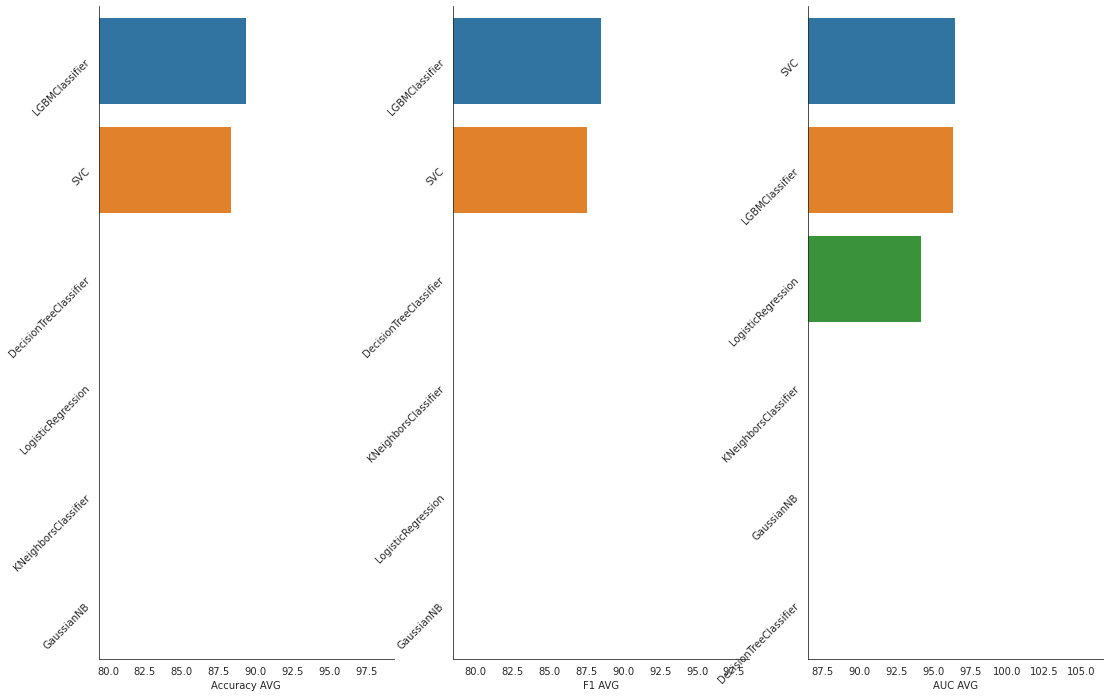

In [0]:
plot_metrics(sorted_acc_df3, sorted_f1_df3, sorted_auc_df3)

**Seach optimal parameters for models**
???

In [0]:
pipe = Pipeline([('count',CountVectorizer(analyzer='word', tokenizer=None,lowercase=False,ngram_range=(1,2),binary=True)),('tfidf', TfidfTransformer()),('svd', TruncatedSVD(n_components=300, random_state=42))])#

In [0]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

In [0]:
models = [
        GaussianNB(),
        SVC(probability=True),
        LogisticRegression(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(),
        lgb.LGBMClassifier()]
param_dists = [param_dist_naive, param_dist_svm, param_dist_lr, param_dist_dt, param_dist_knn, param_dist_lgb]

In [0]:
%%time
best_estimator = search_best_parameters(models, param_dists, X_train, y_train)

CPU times: user 16.5 s, sys: 1.32 s, total: 17.8 s
Wall time: 5min 37s


In [0]:
for i in range(len(models)):
    print(best_estimator[i])

GaussianNB(priors=None, var_smoothing=1e-09)
SVC(C=2.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=1.0, kernel='sigmoid',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
LogisticRegression(C=9.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=58, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
              

In [0]:
# copy optimal parameters into models
model_naive = GaussianNB(priors=None, var_smoothing=1e-09)
model_svm = SVC(C=2.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=1.0, kernel='sigmoid',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

model_lr = LogisticRegression(C=9.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
model_dectree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=58, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
model_knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.06999999999999999,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=50,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)#LightGBM by Microsoft.Градиентный бустинг


In [0]:
model_naive.fit(X_train, y_train)
y_pred_naive = model_naive.predict(X_test)

##################
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
###################
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
###################
model_dectree.fit(X_train, y_train)
y_pred_dectree = model_dectree.predict(X_test)
##################
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
#################
model_lgb.fit(X_train, y_train)
y_pred_lgb = model_lgb.predict(X_test)

In [0]:
##Ensemble model after finding optimal parameters
ensemble_clf = VotingClassifier(estimators=[('svm',model_svm),('lr',model_lr),('naive',model_naive),('dectree', model_dectree),
                                            ('knn', model_knn),('lgb',model_lgb)], voting ='hard')

In [0]:
ensemble_clf.fit(X_train, y_train)
y_pre_ensem = ensemble_clf.predict(X_test)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[34 21]
 [ 7 32]]
Confusion matrix, without normalization
[[53  2]
 [ 4 35]]
Confusion matrix, without normalization
[[55  0]
 [14 25]]
Confusion matrix, without normalization
[[52  3]
 [10 29]]
Confusion matrix, without normalization
[[53  2]
 [ 6 33]]
Confusion matrix, without normalization
[[55  0]
 [12 27]]
Confusion matrix, without normalization
[[55  0]
 [10 29]]


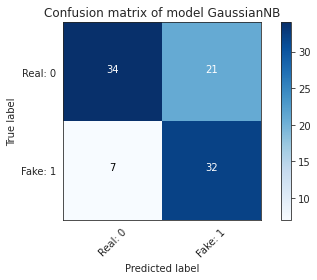

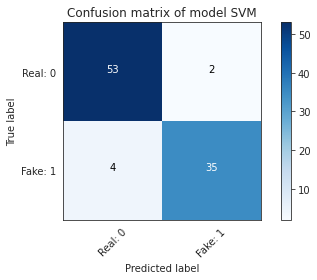

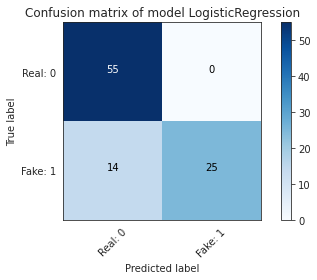

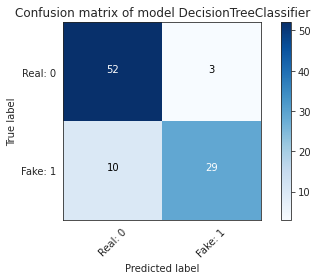

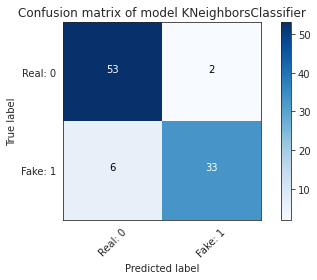

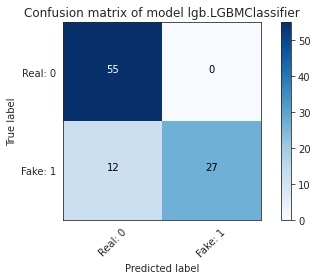

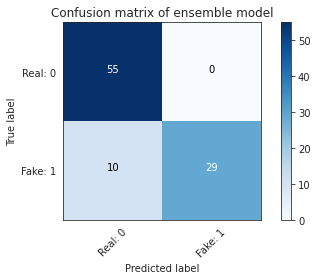

In [0]:
cnf_matrix_naive = confusion_matrix(y_test, y_pred_naive)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_naive, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix of model GaussianNB')
####################
cnf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_svm, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix of model SVM')
######################
cnf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_lr, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix of model LogisticRegression')
######################
cnf_matrix_dectree = confusion_matrix(y_test, y_pred_dectree)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_dectree, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix of model DecisionTreeClassifier')
######################
cnf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_knn, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix of model KNeighborsClassifier')
######################
cnf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_lgb, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix of model lgb.LGBMClassifier')
######################
cnf_matrix_ensem = confusion_matrix(y_test, y_pre_ensem)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_ensem, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix of ensemble model')

In [0]:
y_pre = [y_pred_naive, y_pred_svm, y_pred_lr,y_pred_dectree, y_pred_knn, y_pred_lgb, y_pre_ensem]
names = [ "Naive","SVM", "LogisticRegression"," DecisionTreeClassifie", 
             "Nearest Neighbors", " LightGBM Classifier", "Ensemble Model"]
for  j, name in zip(y_pre, names):
      print('Classification report of'+ name)
      print(classification_report(y_test, j, target_names=['Real', 'Fake']))


Classification report ofNaive
              precision    recall  f1-score   support

        Real       0.83      0.62      0.71        55
        Fake       0.60      0.82      0.70        39

    accuracy                           0.70        94
   macro avg       0.72      0.72      0.70        94
weighted avg       0.74      0.70      0.70        94

Classification report ofSVM
              precision    recall  f1-score   support

        Real       0.93      0.96      0.95        55
        Fake       0.95      0.90      0.92        39

    accuracy                           0.94        94
   macro avg       0.94      0.93      0.93        94
weighted avg       0.94      0.94      0.94        94

Classification report ofLogisticRegression
              precision    recall  f1-score   support

        Real       0.80      1.00      0.89        55
        Fake       1.00      0.64      0.78        39

    accuracy                           0.85        94
   macro avg       0.90    

In [0]:
for  j, name in zip(y_pre, names):
      print('Accuracy score of '+ name, np.around(accuracy_score(y_test, j), decimals=2), 'F1_core',np.around(f1_score(y_test, j,  average='weighted'), decimals=2))
      

Accuracy score of Naive 0.7 F1_core 0.7
Accuracy score of SVM 0.94 F1_core 0.94
Accuracy score of LogisticRegression 0.85 F1_core 0.84
Accuracy score of  DecisionTreeClassifie 0.86 F1_core 0.86
Accuracy score of Nearest Neighbors 0.91 F1_core 0.91
Accuracy score of  LightGBM Classifier 0.87 F1_core 0.87
Accuracy score of Ensemble Model 0.89 F1_core 0.89


In [0]:
from sklearn.externals import joblib
model_paths = [ 'model/Naive.sav','model/SVM.sav', 'model/LogisticRegression.sav','model/DecisionTreeClassifie.sav', 
             'model/Nearest Neighbors.sav', 'model/LightGBM Classifier.sav', 'model/Ensemble_Model.sav']
model_names = [model_svm, model_lr, model_naive, model_dectree,
                model_knn, model_lgb]
for i , j in zip(model_names, model_paths):
    joblib.dump(i, os.path.join(data_path, j))